## Potted grapevine phyllosphere microbiome 16S rRNA gene analysis
## R Analyses

#### Brady L. Welsh, May 2023
  


### Load required packages:

In [ ]:
library(phyloseq)
library(qiime2R)
library(ggplot2)
library(scales)
library(microbiome)
library(tidyverse)
library(ggmap)
library(ggrepel)
library(ggpubr)
library(VennDiagram)
library(osmdata)
library(RColorBrewer)

Also, don't forget to set working directory. (2023_Vineyard_FvW/16S_Bacteria_799Ff-1193R/data/)

### Import QIIME2 files as a Phyloseq Object

In [ ]:
ps<-qza_to_phyloseq(
  features="QIIME2_output/Vineyard-16S-table_filtered.qza",
  taxonomy="QIIME2_output/Vineyard-16S-SILVA-138.qza",
  metadata="QIIME2_output/metadata/Vineyard-16S-metadata_nocontrols.tsv"
)

### Check Prevalence of Identified Taxa

In [ ]:
##Code modified from Callahan et al. 2016: https://doi.org/10.12688/f1000research.8986.2

#What phyla contain the most ASVs?
sort(table(tax_table(ps)[,"Phylum"]), exclude=NULL)

#Compute prevalence of each feature, store as data.frame
prevdf <- apply(X = otu_table(ps),
                MARGIN = ifelse(taxa_are_rows(ps), yes = 1, no = 2),
                FUN = function(x){sum(x > 0)})
#Add taxonomy and total read counts to this data.frame
prevdf <- data.frame(Prevalence = prevdf,
                     TotalAbundance = taxa_sums(ps),
                     tax_table(ps))

#OK, how many ASVs are only found in 1 replicate (we have replicates for each sample).
count(prevdf, vars = Prevalence <= 1)

#2575/3372 ASVs. We'll remove them. What % of samples is 1 replicate?
nsamples(ps)
#38 samples
1/38
#1/148 = 0.02632 x 100 = 2.632%

#Plot prevalance/abundance of each ASV, grouped by phylum, with the proposed prevalence 
# filter threshold line
prevdf1 <- subset(prevdf, Phylum %in% get_taxa_unique(ps,"Phylum"))

ggplot(prevdf1, aes(TotalAbundance, Prevalence / nsamples(ps), color = Phylum)) +
  geom_hline(yintercept=0.02632, alpha=0.5, linetype=2) + geom_point(size=2, alpha=0.7) +
  scale_x_log10() +  xlab("Total Abundance") + ylab("Prevalence [Frac. Samples]") +
  facet_wrap(~Phylum) + theme(legend.position="none")

ggsave("R_output/AbundancePrevalence_Per_phylum.png", 
       width = 19, height = 10, dpi = 300)

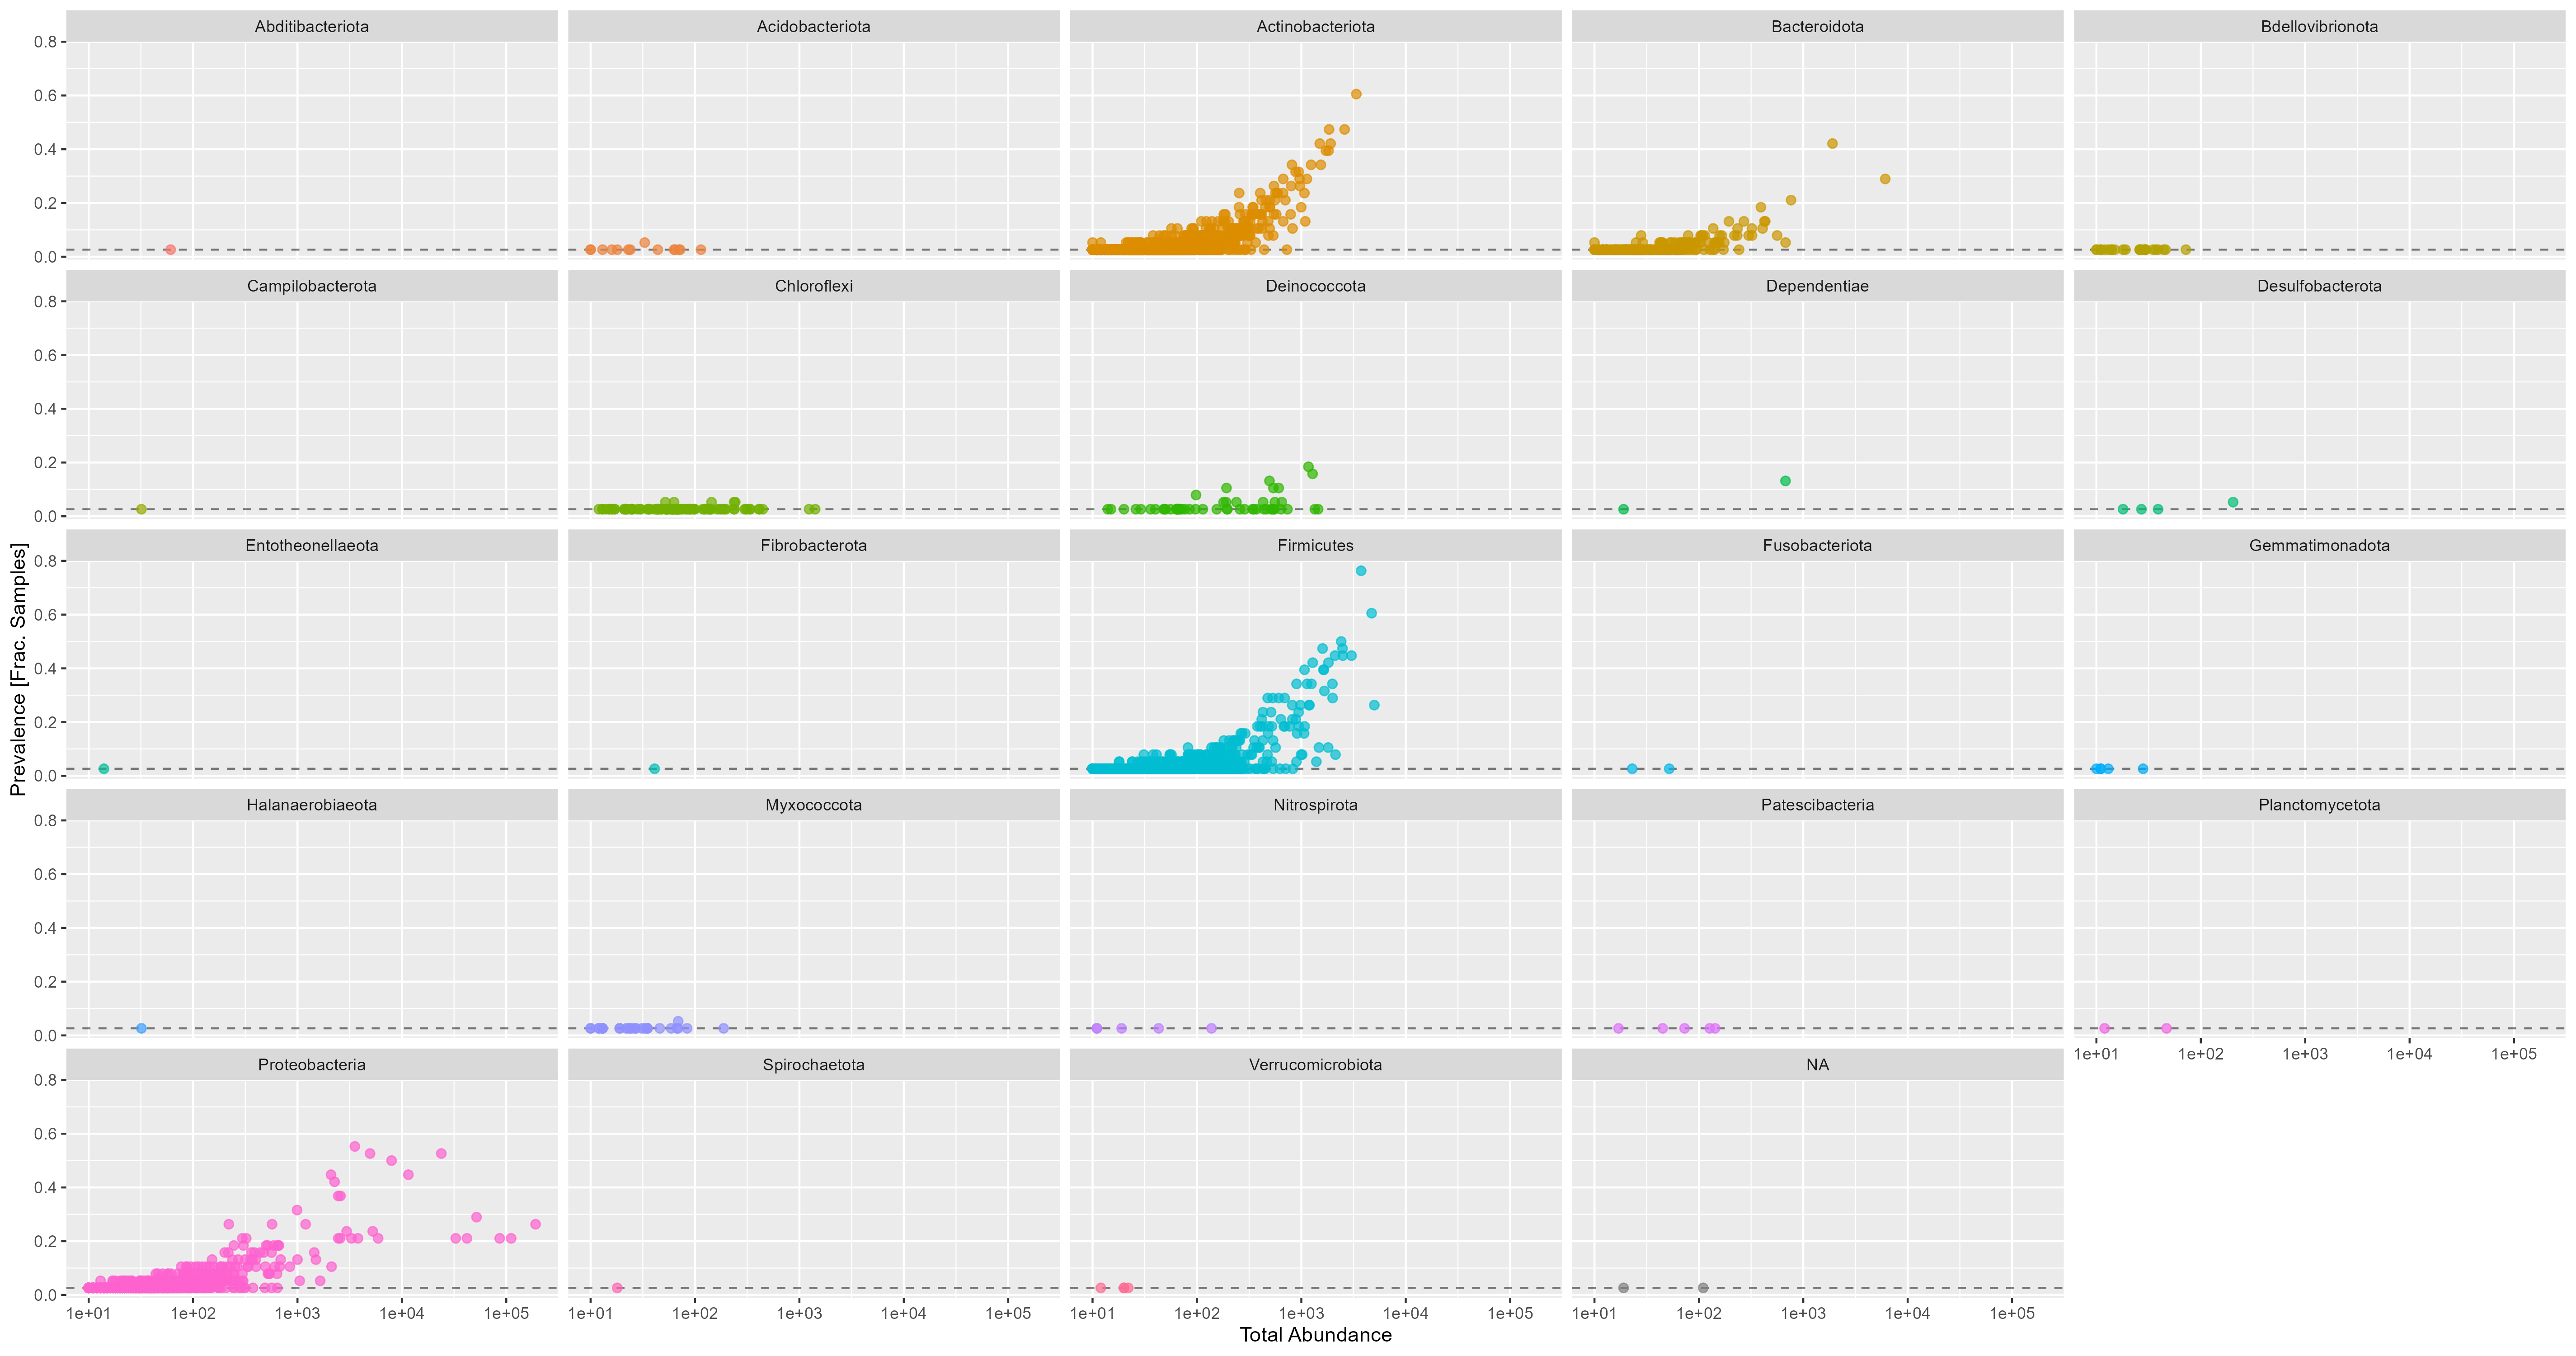

In [ ]:
#Execute prevalence filter
keepTaxa <- rownames(prevdf1)[(prevdf1$Prevalence >= 2)] 
ps.prevF <- prune_taxa(keepTaxa, ps)

### Rarefy

In [ ]:
#Set seed, check the sample with the lowest read count
set.seed(1997)

sort(sample_sums(ps.prevF))

#Rarefy n number of reads where n = read count of samples with fewest reads
ps.prevF.rar <- rarefy_even_depth(ps.prevF, sample.size = 889)

Based on rarefaction plot from QIIME2 and sample sums, a sequencing depth of 518 was chosen as the minimum depth.

This lead to the removal of 31 samples which did not meet the minumum sequencing depth. This removed 8 OTUs which were now no longer present in any samples.

### Fig 2 - Taxanomic Barplots (Family)

First, prepare data to show relative abundance at the Family level.

In [ ]:
library(ggh4x)
library(ggtext)

#Collapse to family level
ps.family <- tax_glom(ps.prevF.rar, taxrank = "Family", NArm = FALSE)

#Extract top 20 most abundant family names, bind to ps sampledata
top20families = names(sort(taxa_sums(ps.family), TRUE)[1:20])
taxtab20 = cbind(tax_table(ps.family), family_20 = NA)
taxtab20[top20families, "family_20"] <- as(tax_table(ps.family)
                                           [top20families, "Family"], "character")
tax_table(ps.family) <- tax_table(taxtab20)

ps.family.ra <- transform_sample_counts(ps.family, function(x) 100 * x/sum(x))

#Melt into a dataframe
pd.family <- psmelt(ps.family.ra)

#Replace NA with 'other', for plotting purposes
pd.family <- arrange(pd.family, stage)
pd.family$family_20[is.na(pd.family$family_20)] <- c("Other")

#Relative abundance of top 20 families?
mean(sample_sums(prune_taxa(top20families, ps.family.ra)))

Then plot!

In [ ]:
library(RColorBrewer)
# Define the number of colors you want
nb.cols <- 22
mycolors <- colorRampPalette(brewer.pal(8, "Set3"))(nb.cols)


#Plot em

BarPlot1 <- ggplot(pd.family, aes(x = (stage), y = (Abundance),
                                  fill = fct_reorder(family_20, -Abundance))) +
  geom_bar(width = 0.9, stat = "identity", position="fill") +
  facet_nested(~vineyard + sample.type, scales = "free", space = "free", ) +
  labs(x = "", y = "Relative abundance") +
  theme(
    axis.text.y = element_text(size=14, face = 'bold'),
    axis.title.y = element_text(size=14, face = 'bold'),
    axis.ticks.y = element_line(size = 1),
    axis.ticks.x = element_line(size = 1),
    axis.text.x = element_text(size = 12),
    axis.title.x = element_blank(),
    legend.title = element_blank(),
    legend.text = element_text(size = 12),
    legend.position = "bottom",
    strip.background = element_blank(),
    strip.text = element_textbox_simple(
      padding = margin(5, 0, 5, 0),
      margin = margin(5, 5, 5, 5),
      size = 10,
      face = "bold",
      halign = 0.5,
      fill = "white",
      box.color = "grey",
      linewidth = 1.5,
      linetype = "solid",),
    panel.background = element_blank()
  ) +
  scale_fill_manual(values = mycolors)+
  scale_y_continuous(labels = scales::percent, expand = c(0, 0))

#Save!
ggsave(filename = "R_output/Figure1.png", 
       width = 15, height = 10, dpi = 300)

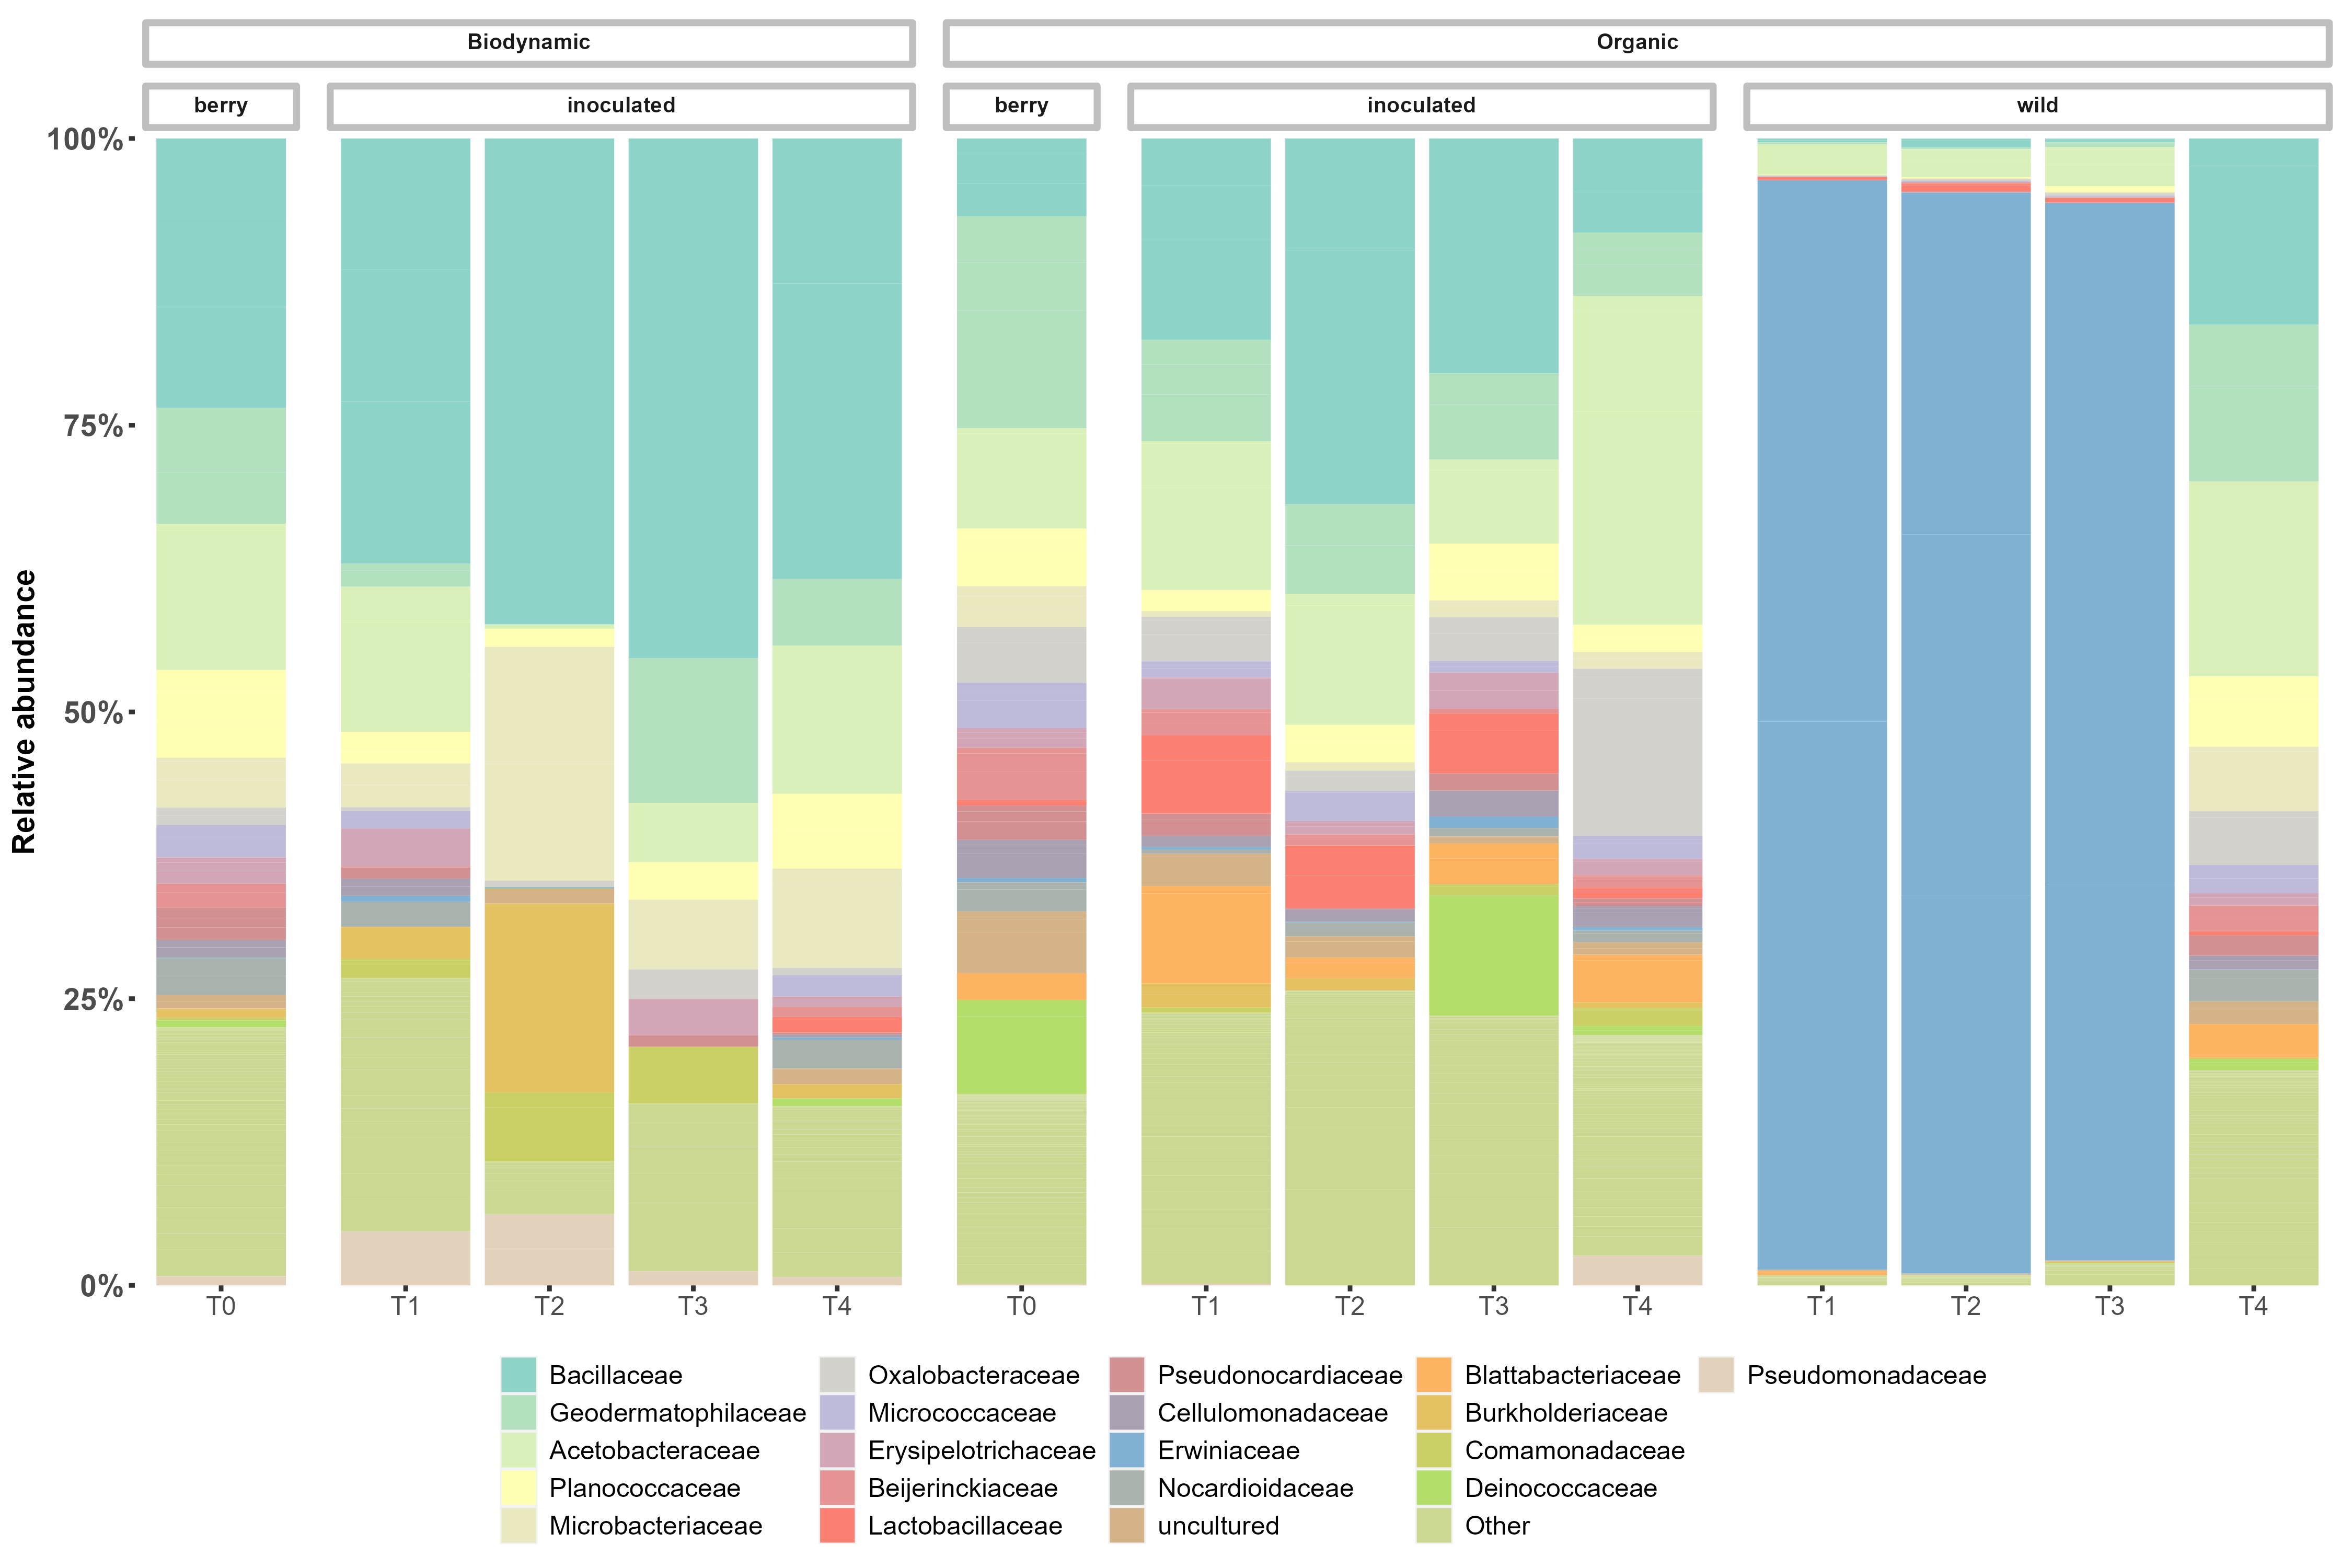

Very rough, many samples failed to sequence or were filtered out. 16S samples omitted from analysis.